In [17]:
import os
import json
from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d


# ---------------------------------------------------------
# 1) JSON 그리드 시각화 (옵션용)
# ---------------------------------------------------------
def visualize_json_grid(json_path: str, cmap: str = "gray"):
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    print(f"[+] Loaded {len(data)} cells from JSON")

    xs, ys, vals = [], [], []
    for k, v in data.items():
        k_clean = k.strip("()")
        x_str, y_str = k_clean.split(",")
        xs.append(int(x_str))
        ys.append(int(y_str))
        vals.append(v)

    xs = np.array(xs)
    ys = np.array(ys)
    vals = np.array(vals, dtype=float)

    x_min, y_min = xs.min(), ys.min()
    xs_shift = xs - x_min
    ys_shift = ys - y_min

    nx = xs_shift.max() + 1
    ny = ys_shift.max() + 1
    print("grid size (ny, nx):", ny, nx)

    grid = np.zeros((ny, nx), dtype=float)
    for x_s, y_s, v in zip(xs_shift, ys_shift, vals):
        grid[y_s, x_s] = v

    plt.figure(figsize=(6, 6))
    plt.imshow(grid, origin="lower", cmap=cmap)
    plt.colorbar(label="value")
    plt.xlabel("x (shifted)")
    plt.ylabel("y (shifted)")
    plt.grid(False)
    plt.show()

    return grid


# ---------------------------------------------------------
# 2) PCD 시각화 (옵션용)
# ---------------------------------------------------------
def visualize_pcd(pcd_path: str,
                  max_points: int = 200_000,
                  use_rgb_if_available: bool = True,
                  show_3d: bool = False):

    pcd = o3d.io.read_point_cloud(pcd_path)
    if pcd.is_empty():
        raise RuntimeError(f"[!] Failed to load or empty PCD: {pcd_path}")

    pts = np.asarray(pcd.points)
    N = pts.shape[0]
    print(f"[+] Loaded point cloud: {N} points")

    if use_rgb_if_available and pcd.has_colors():
        colors = np.asarray(pcd.colors)
        print("[+] Color information found in PCD (using RGB).")
    else:
        print("[!] No usable color information. Using gray.")
        colors = np.tile([[0.5, 0.5, 0.5]], (N, 1))

    if N > max_points:
        idx = np.random.choice(N, max_points, replace=False)
        pts_vis = pts[idx]
        colors_vis = colors[idx]
        print(f"    → subsampled from {N} to {pts_vis.shape[0]} points for plotting")
    else:
        pts_vis = pts
        colors_vis = colors

    x = pts_vis[:, 0]
    y = pts_vis[:, 1]

    print(f"X range: {x.min():.3f} → {x.max():.3f}")
    print(f"Y range: {y.min():.3f} → {y.max():.3f}")

    plt.figure(figsize=(8, 8))
    plt.scatter(x, y, c=colors_vis, s=1)
    plt.axis("equal")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(False)
    plt.show()

    if show_3d:
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(pts_vis[:, 0], pts_vis[:, 1], pts_vis[:, 2],
                   c=colors_vis, s=1)
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        plt.show()

    return pts_vis, colors_vis


# ---------------------------------------------------------
# 3) installable / ignore JSON → 결합 grid 생성
# ---------------------------------------------------------
def build_combined_grid(installable_json_path: str,
                        ignore_json_path: str,
                        visualize: bool = True):
    """
    installable / ignore JSON을 합쳐서 2D 그리드(파이썬 리스트) 생성.

    - installable JSON: 해당 좌표는 1
    - ignore JSON: 해당 좌표는 0
    - 두 JSON 어디에도 없는 좌표: None
    """

    def load_coords(path):
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        coords = {}
        for k, v in data.items():
            if not v:
                continue
            k_clean = k.strip("()")
            x_str, y_str = k_clean.split(",")
            x = int(x_str)
            y = int(y_str)
            coords[(x, y)] = v
        return coords

    install_coords = load_coords(installable_json_path)
    ignore_coords = load_coords(ignore_json_path)

    print(f"[+] installable cells: {len(install_coords)}")
    print(f"[+] ignore cells     : {len(ignore_coords)}")

    all_points = list(install_coords.keys()) + list(ignore_coords.keys())
    xs = [p[0] for p in all_points]
    ys = [p[1] for p in all_points]

    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)

    nx = (x_max - x_min) + 1
    ny = (y_max - y_min) + 1

    print(f"[+] global x range: {x_min} → {x_max}  (nx={nx})")
    print(f"[+] global y range: {y_min} → {y_max}  (ny={ny})")

    grid = [[None for _ in range(nx)] for _ in range(ny)]

    for (x, y) in ignore_coords.keys():
        gx = x - x_min
        gy = y - y_min
        grid[gy][gx] = 0  # ignore

    for (x, y) in install_coords.keys():
        gx = x - x_min
        gy = y - y_min
        grid[gy][gx] = 1  # installable

    if visualize:
        vis_arr = np.full((ny, nx), np.nan, dtype=float)
        for j in range(ny):
            for i in range(nx):
                v = grid[j][i]
                if v is not None:
                    vis_arr[j, i] = v

        plt.figure(figsize=(6, 6))
        im = plt.imshow(vis_arr, origin="lower", cmap="viridis")
        plt.colorbar(im, label="grid value (None=NaN, 0=ignore, 1=installable)")
        plt.xlabel("x (shifted index)")
        plt.ylabel("y (shifted index)")
        plt.grid(False)
        plt.show()

    meta = {
        "x_min": x_min,
        "x_max": x_max,
        "y_min": y_min,
        "y_max": y_max,
        "nx": nx,
        "ny": ny,
    }

    return grid, meta


# ---------------------------------------------------------
# 4) 내부 None → 2로 채우는 함수
# ---------------------------------------------------------
def fill_interior_nulls(grid, interior_value: int = 2):
    """
    grid: 2D list (ny x nx), 값은 {None, 0, 1, ...} 등
    - 바깥에서 연결된 None 은 그대로 유지 (외부)
    - 바깥과 연결되지 않은 None 은 '구멍'으로 보고 interior_value로 채움
    """
    ny = len(grid)
    nx = len(grid[0])

    is_none = np.zeros((ny, nx), dtype=bool)
    for j in range(ny):
        for i in range(nx):
            if grid[j][i] is None:
                is_none[j, i] = True

    visited = np.zeros_like(is_none, dtype=bool)
    q = deque()

    # 경계에 있는 None → 외부로 간주
    for x in range(nx):
        if is_none[0, x]:
            q.append((0, x))
            visited[0, x] = True
        if is_none[ny - 1, x] and not visited[ny - 1, x]:
            q.append((ny - 1, x))
            visited[ny - 1, x] = True

    for y in range(ny):
        if is_none[y, 0] and not visited[y, 0]:
            q.append((y, 0))
            visited[y, 0] = True
        if is_none[y, nx - 1] and not visited[y, nx - 1]:
            q.append((y, nx - 1))
            visited[y, nx - 1] = True

    dirs = [(1, 0), (-1, 0), (0, 1), (0, -1)]

    while q:
        cy, cx = q.popleft()
        for dy, dx in dirs:
            nyy = cy + dy
            nxx = cx + dx
            if 0 <= nyy < ny and 0 <= nxx < nx:
                if is_none[nyy, nxx] and not visited[nyy, nxx]:
                    visited[nyy, nxx] = True
                    q.append((nyy, nxx))

    fill_count = 0
    for j in range(ny):
        for i in range(nx):
            if is_none[j, i] and not visited[j, i]:
                grid[j][i] = interior_value
                fill_count += 1

    print(f"[+] Filled {fill_count} interior None cells with value={interior_value}")
    return grid


# ---------------------------------------------------------
# 5) grid를 .py 모듈로 저장
# ---------------------------------------------------------
def save_grid_as_py_module(grid, output_path: str, var_name: str = "GRID"):
    """
    2D 리스트를 .py 파일로 저장해서 나중에 import 해서 쓰는 용도.
    예: var_name="SEOCHO_GRID" 등.
    """
    import pprint
    dirpath = os.path.dirname(output_path)
    if dirpath:
        os.makedirs(dirpath, exist_ok=True)

    with open(output_path, "w", encoding="utf-8") as f:
        f.write("# Auto-generated grid data\n")
        f.write(f"{var_name} = ")
        pprint.pprint(grid, stream=f, width=120)
    print(f"[+] Saved grid as python module to: {output_path}")


# ---------------------------------------------------------
# 6) 전체 파이프라인을 한 번에 돌리는 함수
# ---------------------------------------------------------
def generate_site_grid_module(
    installable_json_path: str,
    ignore_json_path: str,
    output_py_path: str,
    var_name: str = "SITE_GRID",
    interior_value: int = 2,
    visualize: bool = True,
):
    """
    1) installable / ignore JSON을 결합해서 grid 생성
    2) 내부 None 영역을 interior_value(기본 2)로 채움
    3) (옵션) 시각화
    4) .py 모듈로 저장

    Returns
    -------
    grid : list[list[int | None]]
    meta : dict
    """
    # 1) 결합 grid 생성
    grid, meta = build_combined_grid(
        installable_json_path=installable_json_path,
        ignore_json_path=ignore_json_path,
        visualize=visualize,
    )

    # 2) 내부 None 채우기
    grid = fill_interior_nulls(grid, interior_value=interior_value)

    # 3) (옵션) 최종 grid 시각화
    if visualize:
        ny = meta["ny"]
        nx = meta["nx"]
        vis_arr = np.full((ny, nx), np.nan, dtype=float)
        for j in range(ny):
            for i in range(nx):
                v = grid[j][i]
                if v is not None:
                    vis_arr[j, i] = v

        plt.figure(figsize=(6, 6))
        im = plt.imshow(vis_arr, origin="lower", cmap="viridis")
        plt.colorbar(
            im,
            label="grid value (None=NaN, 0=ignore, 1=installable, 2=inner area)"
        )
        plt.xlabel("x (shifted index)")
        plt.ylabel("y (shifted index)")
        plt.grid(False)
        plt.show()

    # 4) .py 모듈로 저장
    save_grid_as_py_module(grid, output_py_path, var_name=var_name)

    return grid, meta


[+] installable cells: 2657
[+] ignore cells     : 2392
[+] global x range: 0 → 89  (nx=90)
[+] global y range: 0 → 110  (ny=111)


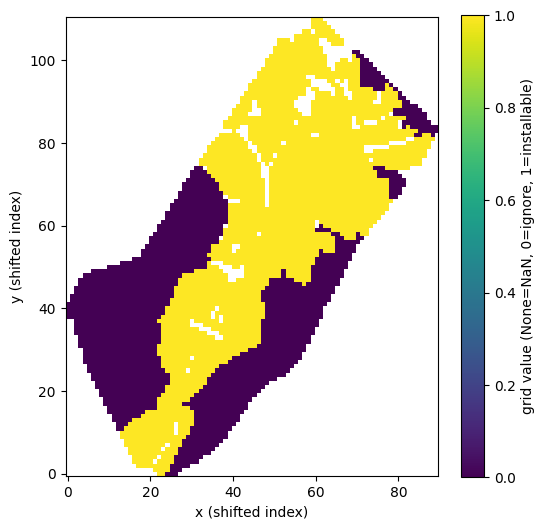

[+] Filled 173 interior None cells with value=2


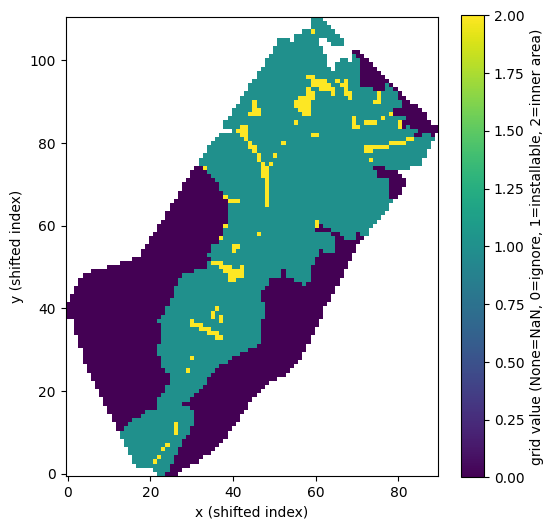

[+] Saved grid as python module to: /workspace/MAPS/gangjin/combined_grid.py


In [19]:


# ---------------------------------------------------------
# 7) 예시 실행 (경로만 바꿔서 재사용)
# ---------------------------------------------------------
if __name__ == "__main__":
    # 서초 현장 예시
    grid, meta = generate_site_grid_module(
        installable_json_path="/workspace/MAPS/gangjin/installable_map/installable_grid.json",
        ignore_json_path="/workspace/MAPS/gangjin/ignore_map/ignore_grid.json",
        output_py_path="/workspace/MAPS/gangjin/combined_grid.py",
        var_name="SEOCHO_GRID",
        interior_value=2,
        visualize=True,
    )
